# Perform segmentation of fluorescent nuclei

In [1]:
# required modules : numpy, matplotlib, stardist, tqdm, tifffile, csbdeep, cv2

from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = None
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import imageio
from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize

from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist.matching import matching, matching_dataset
from stardist.models import Config2D, StarDist2D, StarDistData2D

import cv2

lbl_cmap = random_label_cmap()

# I. Load the images

In [16]:
imgs = imageio.volread("D:\Hugo\Migration\Position1/Position1.tif")

batch = []
for im in imgs:
    batch.append(cv2.resize(im, (220, 220)))
imgs = np.array(batch)

print(imgs.shape)

(54, 220, 220)


# II. Load the segmentation model

For now we use a pretrained model from https://arxiv.org/abs/1806.03535.

In [17]:
model = StarDist2D.from_pretrained('2D_versatile_fluo')

Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


# III. Check predictions on a single image

(220, 220)


Text(0.5, 1.0, 'Number of detected cells: 11.')

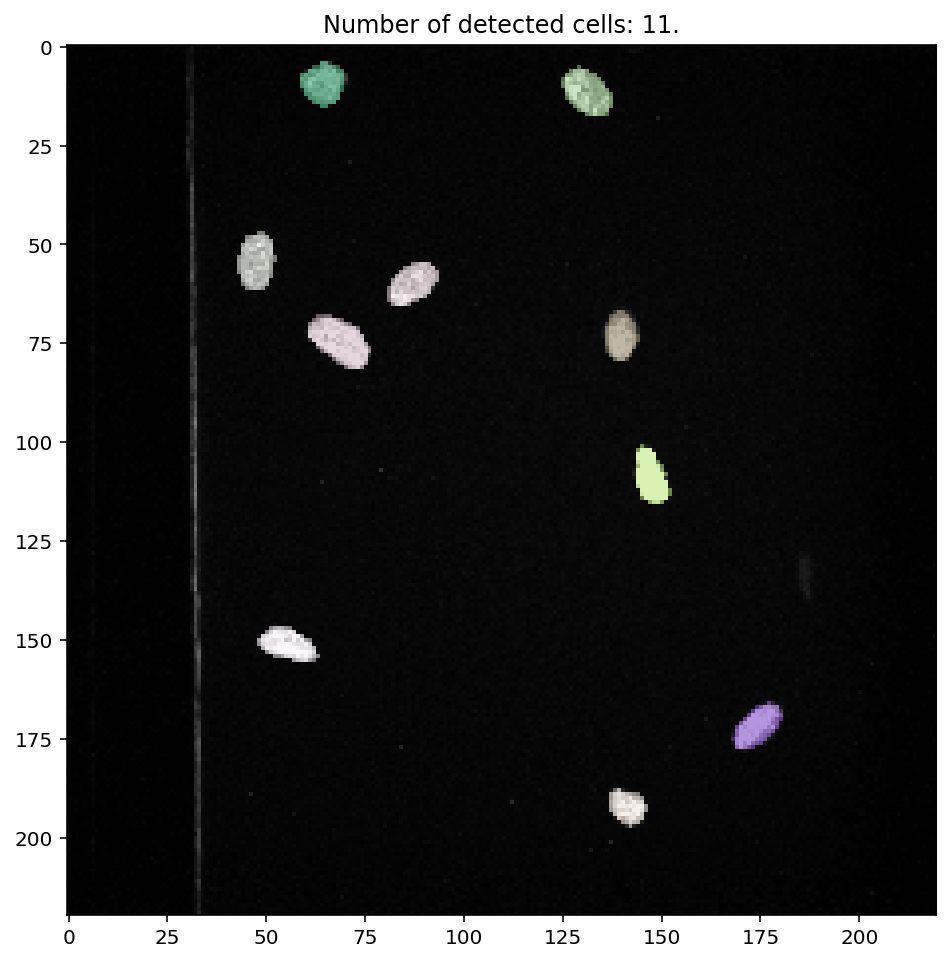

In [18]:
# take one image
img = normalize(imgs[2])
print(img.shape)

# make prediction
labels, details = model.predict_instances(img)
nb_detected_cells = np.unique(labels).size

# display predictions
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(img, clim=(0,1), cmap='gray')
ax.imshow(labels, cmap=lbl_cmap, alpha=0.5)
ax.set_title(f"Number of detected cells: {nb_detected_cells}.")

# IV. Make predictions on the full dataset

In [22]:
from skimage.transform import resize
import time

# CHANGE SAVE PATH here
save_path = "D:/Hugo/Migration/Predictions/Predictions_Position1_test.tif"
    
batch_predictions = []
t0 = time.time()
for im in imgs:
    labels, _ = model.predict_instances(normalize(im))
    batch_predictions.append(cv2.resize(labels, (2048, 2048), interpolation=cv2.INTER_NEAREST ))  # resize the mask to 2048x2048, without interpolation
#     batch_predictions.append(labels)  # if the above doesn't work, and resize in ImageJ after (with interpolation == None)
predictions = np.array(batch_predictions, dtype=np.uint8)
print(f"Predictions duration : {round(time.time() - t0, 2)} sec.")

print(predictions.shape)
    
imageio.volwrite(save_path, predictions)

Predictions duration : 2.31 sec.
(54, 2048, 2048)
